## CNN  en sepecifier une station

In [11]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import  mean_absolute_error, mean_squared_error, r2_score
from tensorflow.keras import layers , callbacks,optimizers,models
import matplotlib.pyplot as plt

traite time serise data 

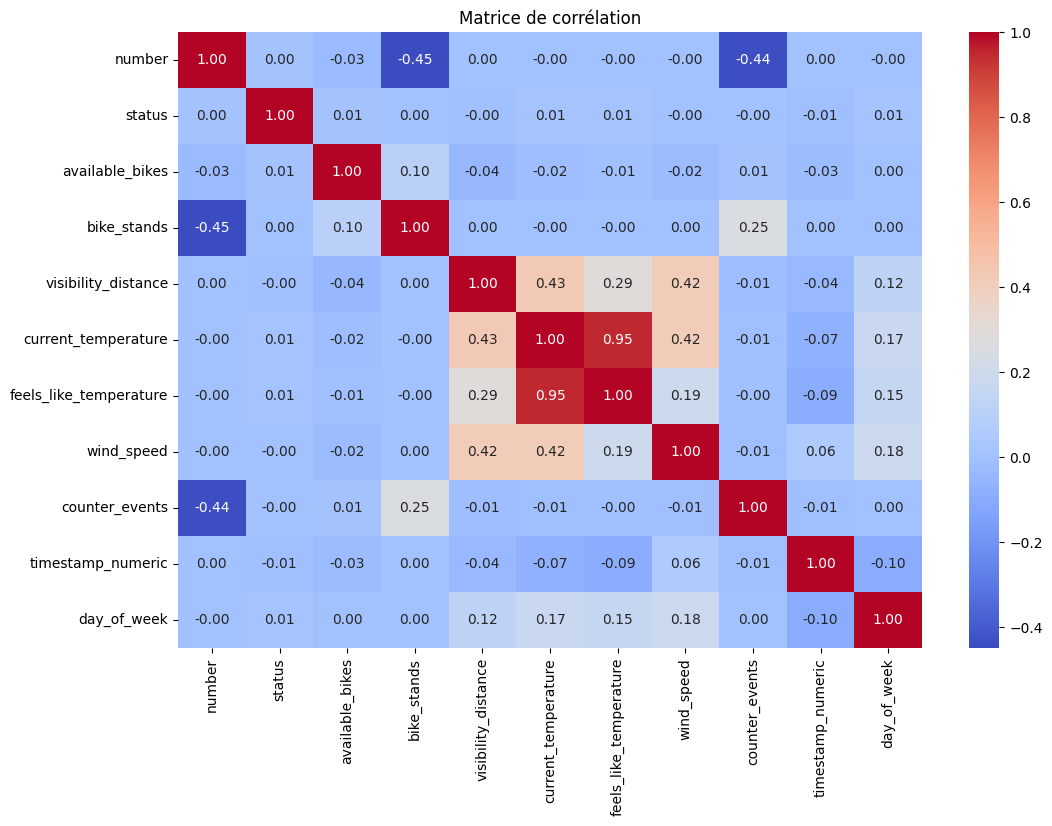

In [23]:

from sklearn.discriminant_analysis import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import KFold


file_path = 'merged_all_bikes_weather_events.csv'
data = pd.read_csv(file_path)
data['timestamp'] = pd.to_datetime(data['timestamp'])
data['timestamp_numeric'] = data['timestamp'].astype('int64') // 10**9 ##en secondes UNIX
data['day_of_week'] = pd.to_datetime(data['timestamp']).dt.dayofweek
data = data.drop(columns=['timestamp','is_rainy','available_bike_stands'])


plt.figure(figsize=(12, 8))
sns.heatmap(data.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Matrice de corrélation")
plt.show()

grouped = data.groupby('number')
group = grouped.get_group(44)  
group=group.sort_index()

X = group.drop(columns=['available_bikes'])
y = group['available_bikes']
    
standardScale_feature=['status','visibility_distance','current_temperature','feels_like_temperature','wind_speed','counter_events','timestamp_numeric','day_of_week']

scaler_x = StandardScaler()
data_x_scaled = X.copy()
data_x_scaled[standardScale_feature] = scaler_x.fit_transform(X[standardScale_feature])
y_scaled = y.values.reshape(-1, 1)
x_scaled = data_x_scaled.values



In [24]:
# Modèle CNN
def build_model(input_shape):
    model = models.Sequential([
        layers.Conv1D(32, kernel_size=2, activation='relu', padding='same', input_shape=(input_shape)),
        layers.BatchNormalization(),
        
        layers.Flatten(),
        layers.Dense(32, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.2),
        
        layers.Dense(16, activation='relu'),
        layers.BatchNormalization(),
        layers.Dense(1, activation='linear')
    ])
    optimizer = optimizers.Adam(learning_rate=0.001)
    model.compile(
        optimizer=optimizer,
        loss='mse',
        metrics=['mae', 'mse']
    )
    return model

callback_list = [
    callbacks.EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True
    ),
    callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=3,
        min_lr=1e-5
    )
]



In [25]:
#random
test_size = 0.2  # 20 % pour le test
val_size = 0.2   # 20 % pour validation


X_train_full, X_test, y_train_full, y_test = train_test_split(x_scaled, y_scaled, test_size=test_size, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=val_size, random_state=42)

# Reshape pour CNN
X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_val = X_val.reshape((X_val.shape[0], 1, X_val.shape[1]))
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

# Vérification des formes
print(f"Train shape: {X_train.shape}")
print(f"Validation shape: {X_val.shape}")
print(f"Test shape: {X_test.shape}")

model = build_model(input_shape=(X_train.shape[1], X_train.shape[2]))

# Entraînement du modèle
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=30,
    batch_size=16,
    shuffle=True,
    callbacks=callback_list,
    verbose=1
)

# Prédictions sur l'ensemble de test
predictions = model.predict(X_test)

# Calcul des métriques pour l'ensemble de test
mse = mean_squared_error(y_test, predictions)
mae = mean_absolute_error(y_test, predictions)
r2 = r2_score(y_test, predictions)

# Calcul du MAPE (Mean Absolute Percentage Error)
non_zero_indices = y_test > 1e-3  # Éviter les divisions par zéro ou très petites valeurs
if non_zero_indices.sum() > 0:  # Vérifier qu'il y a des valeurs valides
    mape = np.mean(
        np.abs((y_test[non_zero_indices] - predictions[non_zero_indices]) / y_test[non_zero_indices])
    ) * 100
else:
    mape = np.inf

# Affichage des métriques
print(f"MAPE: {mape:.2f}%, MSE: {mse:.4f}, MAE: {mae:.4f}, R²: {r2:.4f}")

Train shape: (1995, 1, 10)
Validation shape: (499, 1, 10)
Test shape: (624, 1, 10)
Epoch 1/30


/Users/yongjiazeng/Library/Python/3.9/lib/python/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 17.7836 - mae: 3.2741 - mse: 17.7836 - val_loss: 25.9458 - val_mae: 4.1631 - val_mse: 25.9458 - learning_rate: 0.0010
Epoch 2/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 12.8345 - mae: 2.7356 - mse: 12.8345 - val_loss: 14.8003 - val_mae: 2.8757 - val_mse: 14.8003 - learning_rate: 0.0010
Epoch 3/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 8.3749 - mae: 2.2144 - mse: 8.3749 - val_loss: 8.2090 - val_mae: 2.1481 - val_mse: 8.2090 - learning_rate: 0.0010
Epoch 4/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6.6681 - mae: 1.9711 - mse: 6.6681 - val_loss: 6.1050 - val_mae: 1.8826 - val_mse: 6.1050 - learning_rate: 0.0010
Epoch 5/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6.7124 - mae: 2.0561 - mse: 6.7124 - val_loss: 6.1340 - val_mae: 2.0191 - val_mse: 6.1340 - learning_rate: 0.0010
Epoch 6/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5.7306 - mae: 1.8917 - mse: 5.7306 - val_loss: 6.1188 - val_mae: 1.9369 -

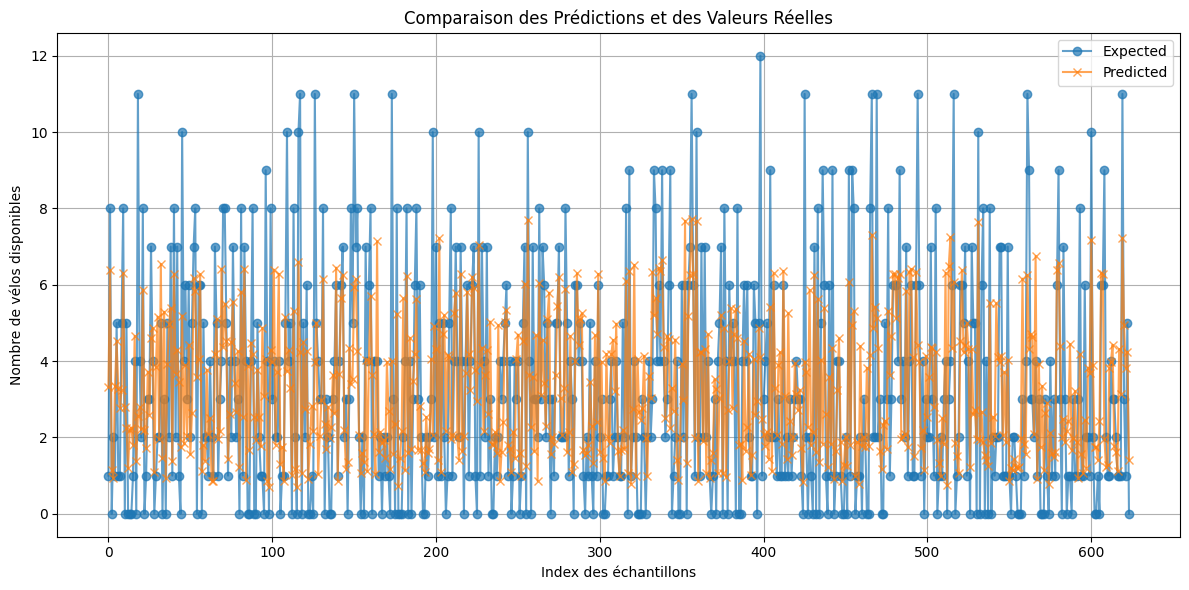

In [26]:
import matplotlib.pyplot as plt

# Tracer les résultats pour comparer les valeurs réelles et prédites
plt.figure(figsize=(12, 6))
plt.plot(range(len(y_test)), y_test, label='Expected', linestyle='-', marker='o', alpha=0.7)
plt.plot(range(len(predictions)), predictions, label='Predicted', linestyle='-', marker='x', alpha=0.7)

# Ajout des détails au graphique
plt.title("Comparaison des Prédictions et des Valeurs Réelles")
plt.xlabel("Index des échantillons")
plt.ylabel("Nombre de vélos disponibles")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


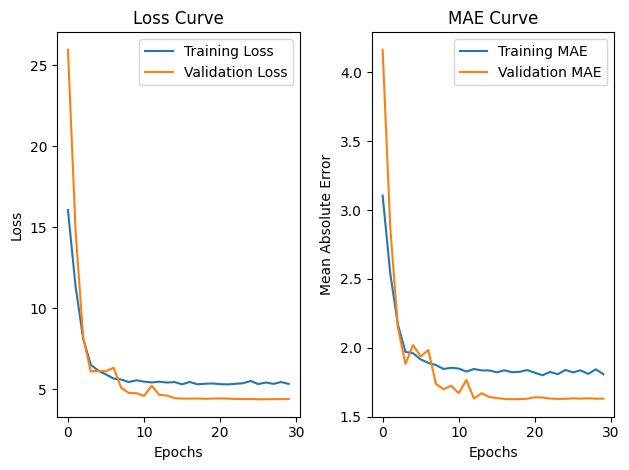

In [ ]:
# Courbe de perte
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Courbe des métriques (MAE ici)
plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('MAE Curve')
plt.xlabel('Epochs')
plt.ylabel('Mean Absolute Error')
plt.legend()

plt.tight_layout()
plt.show()

In [18]:

# Validation croisée avec ensemble de validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)
results = []

for fold, (train_index, test_index) in enumerate(kf.split(x_scaled)):
    print(f"\n--- Fold {fold + 1} ---")
    
    # Séparation des données pour ce pli
    X_train_full, X_test = x_scaled[train_index], x_scaled[test_index]
    y_train_full, y_test = y_scaled[train_index], y_scaled[test_index]
    
    # Ajout d'une validation explicite (10 % de X_train_full)
    val_split = int(0.1 * len(X_train_full))
    X_train, X_val = X_train_full[:-val_split], X_train_full[-val_split:]
    y_train, y_val = y_train_full[:-val_split], y_train_full[-val_split:]
    
    # Reshape pour CNN
    X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
    X_val = X_val.reshape((X_val.shape[0], 1, X_val.shape[1]))
    X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))
    
    # Construire et entraîner le modèle
    model = build_model(input_shape=(X_train.shape[1], X_train.shape[2]))
    
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=30,
        batch_size=16,
        shuffle=False,
        callbacks=callback_list,
        verbose=1
    )
    
    # Prédictions et calcul des métriques
    predictions = model.predict(X_test)
    mse = mean_squared_error(y_test, predictions)
    mae = mean_absolute_error(y_test, predictions)
    r2 = r2_score(y_test, predictions)
    
    # Calcul du MAPE
    non_zero_indices = y_test > 1e-3  # Éviter les divisions par zéro ou petites valeurs
    if non_zero_indices.sum() > 0:
        mape = np.mean(
            np.abs((y_test[non_zero_indices] - predictions[non_zero_indices]) / y_test[non_zero_indices])
        ) * 100
    else:
        mape = np.inf
    
    # Affichage des métriques pour ce pli
    print(f"Fold {fold + 1} - MAPE: {mape:.2f}%, MSE: {mse:.4f}, MAE: {mae:.4f}, R²: {r2:.4f}")
    
    # Stocker les résultats
    results.append({
        'Fold': fold + 1,
        'MAPE': mape,
        'MSE': mse,
        'MAE': mae,
        'R²': r2
    })

# Résumé des résultats
for result in results:
    print(result)


--- Fold 1 ---
Epoch 1/30


/Users/yongjiazeng/Library/Python/3.9/lib/python/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


141/141 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 17.7937 - mae: 3.2441 - mse: 17.7937 - val_loss: 13.6066 - val_mae: 2.8351 - val_mse: 13.6066 - learning_rate: 0.0010
Epoch 2/30
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 13.2864 - mae: 2.6803 - mse: 13.2864 - val_loss: 13.6430 - val_mae: 2.8985 - val_mse: 13.6430 - learning_rate: 0.0010
Epoch 3/30
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 9.8633 - mae: 2.3153 - mse: 9.8633 - val_loss: 18.6373 - val_mae: 3.3251 - val_mse: 18.6373 - learning_rate: 0.0010
Epoch 4/30
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 8.0451 - mae: 2.1753 - mse: 8.0451 - val_loss: 15.6020 - val_mae: 3.1180 - val_mse: 15.6020 - learning_rate: 0.0010
Epoch 5/30
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 7.5721 - mae: 2.1813 - mse: 7.5721 - val_loss: 11.5540 - val_mae: 2.8384 - val_mse: 11.5540 - learning_rate: 2.0000e-04
Epoch 6/30
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 7.3523 - mae: 2.1605 - mse: 7.3523 - val_loss: 10.9303 - val_ma

/Users/yongjiazeng/Library/Python/3.9/lib/python/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


141/141 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 17.0499 - mae: 3.1587 - mse: 17.0499 - val_loss: 12.6132 - val_mae: 2.8375 - val_mse: 12.6132 - learning_rate: 0.0010
Epoch 2/30
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 12.7248 - mae: 2.6468 - mse: 12.7248 - val_loss: 10.7663 - val_mae: 2.8211 - val_mse: 10.7663 - learning_rate: 0.0010
Epoch 3/30
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 9.1245 - mae: 2.2540 - mse: 9.1245 - val_loss: 11.7831 - val_mae: 2.7894 - val_mse: 11.7831 - learning_rate: 0.0010
Epoch 4/30
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 7.6019 - mae: 2.1519 - mse: 7.6019 - val_loss: 10.7738 - val_mae: 2.5819 - val_mse: 10.7738 - learning_rate: 0.0010
Epoch 5/30
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 7.2832 - mae: 2.1794 - mse: 7.2832 - val_loss: 13.6166 - val_mae: 2.9013 - val_mse: 13.6166 - learning_rate: 0.0010
Epoch 6/30
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6.9195 - mae: 2.1339 - mse: 6.9195 - val_loss: 10.5901 - val_mae: 2

/Users/yongjiazeng/Library/Python/3.9/lib/python/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


141/141 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 18.4429 - mae: 3.2509 - mse: 18.4429 - val_loss: 15.0465 - val_mae: 2.9968 - val_mse: 15.0465 - learning_rate: 0.0010
Epoch 2/30
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 13.2797 - mae: 2.6805 - mse: 13.2797 - val_loss: 11.2893 - val_mae: 2.6889 - val_mse: 11.2893 - learning_rate: 0.0010
Epoch 3/30
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 10.0365 - mae: 2.3759 - mse: 10.0365 - val_loss: 19.6588 - val_mae: 3.5467 - val_mse: 19.6588 - learning_rate: 0.0010
Epoch 4/30
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 8.1662 - mae: 2.2452 - mse: 8.1662 - val_loss: 11.2606 - val_mae: 2.7414 - val_mse: 11.2606 - learning_rate: 0.0010
Epoch 5/30
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 7.5053 - mae: 2.2141 - mse: 7.5053 - val_loss: 12.4535 - val_mae: 2.8889 - val_mse: 12.4535 - learning_rate: 0.0010
Epoch 6/30
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 7.0835 - mae: 2.1745 - mse: 7.0835 - val_loss: 7.6916 - val_mae: 

/Users/yongjiazeng/Library/Python/3.9/lib/python/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


141/141 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 18.1424 - mae: 3.2463 - mse: 18.1424 - val_loss: 15.7279 - val_mae: 3.0461 - val_mse: 15.7279 - learning_rate: 0.0010
Epoch 2/30
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 12.7107 - mae: 2.6470 - mse: 12.7107 - val_loss: 21.5866 - val_mae: 3.5814 - val_mse: 21.5866 - learning_rate: 0.0010
Epoch 3/30
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 9.4724 - mae: 2.3013 - mse: 9.4724 - val_loss: 16.2624 - val_mae: 3.2510 - val_mse: 16.2624 - learning_rate: 0.0010
Epoch 4/30
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 7.7277 - mae: 2.1435 - mse: 7.7277 - val_loss: 12.3654 - val_mae: 2.9579 - val_mse: 12.3654 - learning_rate: 0.0010
Epoch 5/30
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 7.1976 - mae: 2.1349 - mse: 7.1976 - val_loss: 15.3122 - val_mae: 3.3223 - val_mse: 15.3122 - learning_rate: 0.0010
Epoch 6/30
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 7.1473 - mae: 2.1519 - mse: 7.1473 - val_loss: 12.8917 - val_mae: 3

/Users/yongjiazeng/Library/Python/3.9/lib/python/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


141/141 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 17.8042 - mae: 3.1852 - mse: 17.8042 - val_loss: 12.3005 - val_mae: 2.7559 - val_mse: 12.3005 - learning_rate: 0.0010
Epoch 2/30
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 12.7159 - mae: 2.6456 - mse: 12.7159 - val_loss: 12.5220 - val_mae: 2.8254 - val_mse: 12.5220 - learning_rate: 0.0010
Epoch 3/30
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 9.3578 - mae: 2.2901 - mse: 9.3578 - val_loss: 12.2349 - val_mae: 2.8571 - val_mse: 12.2349 - learning_rate: 0.0010
Epoch 4/30
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 7.8473 - mae: 2.1791 - mse: 7.8473 - val_loss: 16.8188 - val_mae: 3.4819 - val_mse: 16.8188 - learning_rate: 0.0010
Epoch 5/30
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 7.4971 - mae: 2.2032 - mse: 7.4971 - val_loss: 11.1682 - val_mae: 2.7017 - val_mse: 11.1682 - learning_rate: 0.0010
Epoch 6/30
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 7.1066 - mae: 2.1751 - mse: 7.1066 - val_loss: 12.3216 - val_mae: 2

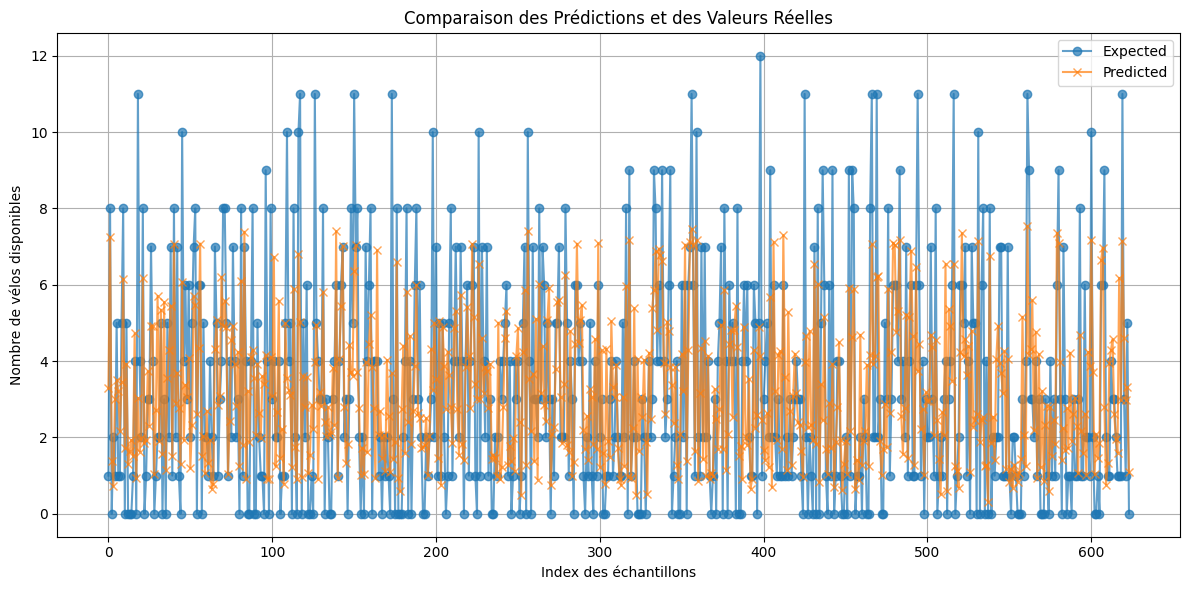

In [21]:
import matplotlib.pyplot as plt

# Tracer les résultats pour comparer les valeurs réelles et prédites
plt.figure(figsize=(12, 6))
plt.plot(range(len(y_test)), y_test, label='Expected', linestyle='-', marker='o', alpha=0.7)
plt.plot(range(len(predictions)), predictions, label='Predicted', linestyle='-', marker='x', alpha=0.7)

# Ajout des détails au graphique
plt.title("Comparaison des Prédictions et des Valeurs Réelles")
plt.xlabel("Index des échantillons")
plt.ylabel("Nombre de vélos disponibles")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
